## Experiments with Dakota `genz`

In [160]:
# import statements
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pk

In [127]:
# special imports
from itertools import product
from run_dakota_genz import *

In [128]:
# pick problem
template_file = "dakota.in.template"
dimension = 64
analysis_components = "cp1"

In [129]:
# pick kwargs
kwargs_list = [{"method": "random", "seed": int("9"*(j + 1))} for j in range(3)]
kwargs_list += [{"method": method, "latinize": latinize} for method, latinize in product(("halton", "hammersley"), (False, True))]

In [130]:
# pick number of samples
nb_of_samples = 2**np.arange(1, 15)

In [131]:
# load results
if os.path.isfile("results.pk"):
    with open("results.pk", "rb") as io:
        results = pk.load(io)
else:
    results = dict()

In [132]:
# run
for kwargs in kwargs_list:
    print(", ".join([f"{k} = {v}" for k, v in kwargs.items()]))
    for n in nb_of_samples:
        inputs = {"dimension": dimension, "analysis_components": analysis_components, "nb_of_samples": n}
        inputs = {**inputs, **kwargs}
        key = "_".join([f"{k}_{v}" for k, v in inputs.items()])
        if not key in results.keys():
            print(n, end=" ")
            for k, v in inputs.items():
                results[key] = dakota_genz(**inputs)
    print("done!")

method = random, seed = 9
2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 done!
method = random, seed = 99
2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 done!
method = random, seed = 999
2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 done!
method = halton, latinize = False
2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 done!
method = halton, latinize = True
2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 done!
method = hammersley, latinize = False
2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 done!
method = hammersley, latinize = True
2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 done!


In [133]:
# save results
with open("results.pk", "wb") as io:
    pk.dump(results, io)

In [171]:
# exact results
exact_results = np.loadtxt("reference_solutions.txt")
col = int(analysis_components[-1]) - 1 + (0 if "os" in analysis_components else 3)
row = int(np.log2(dimension))
exact_result = exact_results[row, col]

In [154]:
# join results for different number of samples
parsed_results = dict()
for k, v in results.items():
    n = int(k.split("nb_of_samples_")[1].split("_")[0])
    k_filtered = k.replace(f"_nb_of_samples_{n}", "")
    if not k_filtered in parsed_results:
        parsed_results[k_filtered] = [list(), list()]
    parsed_results[k_filtered][0].append(n)
    parsed_results[k_filtered][1].append(v)

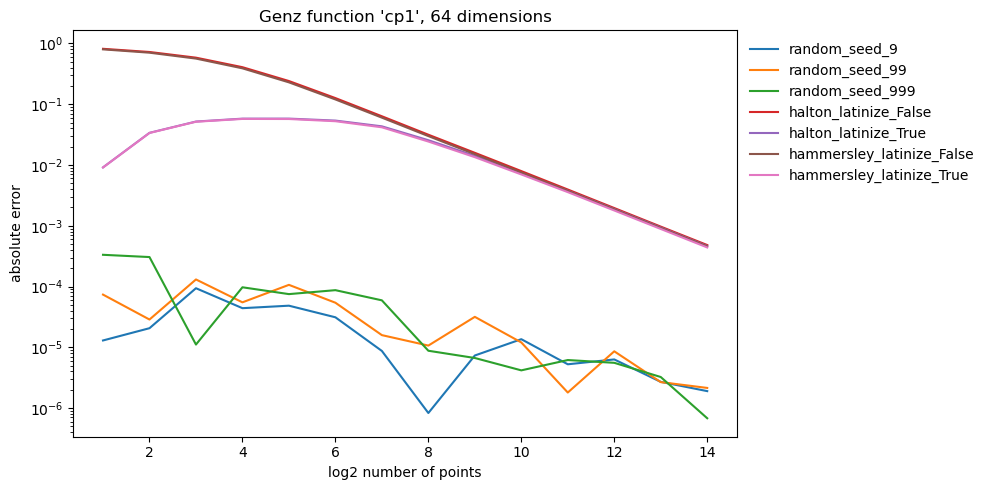

In [169]:
# plot
_, ax = plt.subplots(figsize=(10, 5))
unique_name = os.path.commonprefix(list(parsed_results.keys()))
for k, v in parsed_results.items():
    ax.plot(np.log2(v[0]), np.abs(v[1] - exact_result), label=k.replace(unique_name, ""))
ax.set_yscale("log")
ax.set_ylabel("absolute error")
ax.set_xlabel("log2 number of points")
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title(f"Genz function '{analysis_components}', {dimension} dimensions")
plt.tight_layout()